# Predictive Maintenance with Linear Regression
## RMBR4-2 Robot Current Analysis

**Student Name:** Prajesh Bhatt 
**Student ID:** 9046277
**Date:** February 2026

---

## Project Overview

This notebook analyzes RMBR4-2 robot current consumption data to implement predictive maintenance using:
- Linear regression for modeling normal behavior
- Residual analysis for anomaly detection
- Alert/Error system for early failure warnings
- **2-Week predictive dashboard with failure forecasting**

**Dataset:** 39,672 current measurements across 8 robot axes

## 1. Setup and Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Custom modules
import sys
sys.path.append('../src')

from data_preprocessing_robot import load_and_preprocess_robot_data, save_preprocessed_data
from regression import AxisRegressionModel, MultiAxisRegressionSystem
from data_generator import SyntheticDataGenerator
from preprocessing import DataPreprocessor
from anomaly_detection import AnomalyDetector, discover_thresholds_from_residuals
from visualization import (
    plot_regression_with_alerts,
    plot_residual_analysis,
    plot_all_axes_comparison,
    plot_anomaly_summary,
    create_results_summary_report
)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ All modules imported successfully")

✅ All modules imported successfully


## 2. Load and Preprocess Data

**Note:** Your data has a specific format:
- Column names: `"Axis #1"`, `"Axis #2"`, etc.
- Timestamps in ISO format: `"2022-10-17T12:18:23.660Z"`
- Extra `"Trait"` column

We'll preprocess this to a standardized format.

In [2]:
# Load and preprocess the RMBR4-2 robot data
training_data = load_and_preprocess_robot_data('../data/raw/RMBR4-2_export_test.csv')

📂 Loading data from ../data/raw/RMBR4-2_export_test.csv...
✅ Loaded 39672 rows, 16 columns
📊 Original columns: ['Trait', 'Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8', 'Axis #9', 'Axis #10', 'Axis #11', 'Axis #12', 'Axis #13', 'Axis #14', 'Time']
✅ Removed 'Trait' column
✅ Converted timestamps to seconds (0 to 80794.97s)
✅ Renamed 14 axis columns
   Example: 'Axis #1' -> 'Axis_1'
✅ Kept columns: ['Time', 'Axis_1', 'Axis_2', 'Axis_3', 'Axis_4', 'Axis_5', 'Axis_6', 'Axis_7', 'Axis_8']

📊 Final dataset shape: (39672, 9)
📊 Time range: 0.00s to 80794.97s
📊 Data summary:
               Time        Axis_1        Axis_2        Axis_3        Axis_4  \
count  39672.000000  39672.000000  39672.000000  39672.000000  39672.000000   
mean   40783.824738      0.725743      3.613374      2.710336      0.620222   
std    23131.089818      2.162120      6.879962      5.111901      1.574897   
min        0.000000      0.000000      0.000000      0.000000      0.00

In [3]:
# Display first few rows
print("\n📊 First 10 rows of preprocessed data:\n")
display(training_data.head(10))

print("\n📊 Last 10 rows:\n")
display(training_data.tail(10))


📊 First 10 rows of preprocessed data:



,Time,Axis_1,Axis_2,Axis_3,Axis_4,Axis_5,Axis_6,Axis_7,Axis_8
0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,9.304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,11.234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,13.122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,15.048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,16.869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



📊 Last 10 rows:



,Time,Axis_1,Axis_2,Axis_3,Axis_4,Axis_5,Axis_6,Axis_7,Axis_8
39662,80777.960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39663,80779.827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39664,80781.749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39665,80783.578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39666,80785.516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39667,80787.389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39668,80789.328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39669,80791.178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39670,80793.046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39671,80794.968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Save preprocessed data
save_preprocessed_data(training_data, '../data/processed/robot_data_clean.csv')


💾 Preprocessed data saved to ../data/processed/robot_data_clean.csv


In [5]:
# Exploratory Data Analysis
print("📊 Dataset Statistics:\n")
display(training_data.describe())

print("\n🔍 Checking for missing values:")
print(training_data.isnull().sum())

print("\n📈 Data types:")
print(training_data.dtypes)

📊 Dataset Statistics:



,Time,Axis_1,Axis_2,Axis_3,Axis_4,Axis_5,Axis_6,Axis_7,Axis_8
count,39672.000000,39672.000000,39672.000000,39672.000000,39672.000000,39672.000000,39672.000000,39672.000000,39672.000000
mean,40783.824738,0.725743,3.613374,2.710336,0.620222,0.954521,0.599427,0.870145,0.102214
std,23131.089818,2.162120,6.879962,5.111901,1.574897,2.100186,1.815498,2.166811,0.423075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20778.821500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40829.283500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60809.192250,0.312710,4.217190,4.586190,0.516190,0.800090,0.361330,0.310030,0.078480
max,80794.968000,23.609300,51.713230,41.855560,15.666300,20.750760,20.931420,8.108480,5.905640



🔍 Checking for missing values:
Time      0
Axis_1    0
Axis_2    0
Axis_3    0
Axis_4    0
Axis_5    0
Axis_6    0
Axis_7    0
Axis_8    0
dtype: int64

📈 Data types:
Time      float64
Axis_1    float64
Axis_2    float64
Axis_3    float64
Axis_4    float64
Axis_5    float64
Axis_6    float64
Axis_7    float64
Axis_8    float64
dtype: object


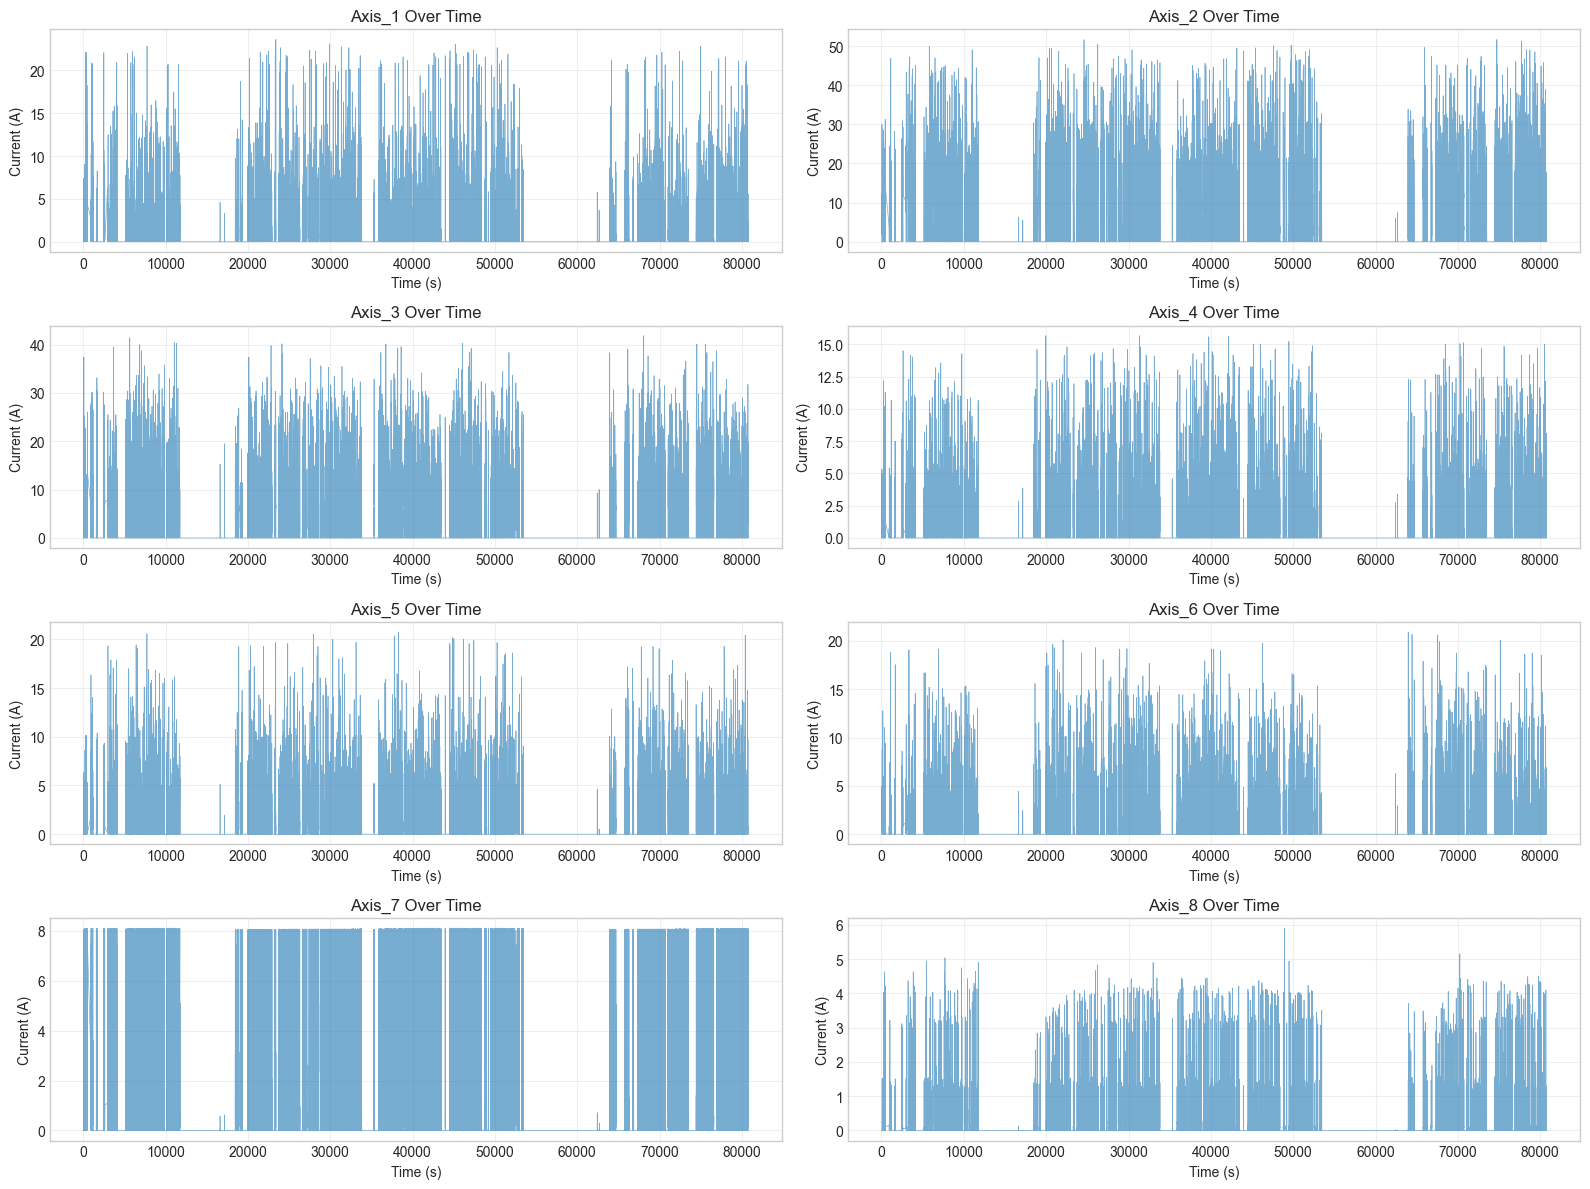

✅ Raw data visualization saved


In [6]:
# Quick visualization of all axes
import os
os.makedirs('../results', exist_ok=True)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

for i in range(1, 9):
    col = f'Axis_{i}'
    if col in training_data.columns:
        axes[i-1].plot(training_data['Time'], training_data[col], alpha=0.6, linewidth=0.5)
        axes[i-1].set_xlabel('Time (s)')
        axes[i-1].set_ylabel('Current (A)')
        axes[i-1].set_title(f'{col} Over Time')
        axes[i-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/raw_data_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Raw data visualization saved")

## 3. Train Regression Models

Train linear regression models for each of the 8 robot axes.

In [7]:
# Initialize multi-axis regression system
regression_system = MultiAxisRegressionSystem()

# Train all 8 axes
regression_system.train_all_axes(training_data, time_column='Time')

🚀 Training regression models for all axes...

✅ Axis 1 trained:
   Slope: -0.000000
   Intercept: 0.730542
   R² Score: 0.0000
   RMSE: 2.1621

✅ Axis 2 trained:
   Slope: 0.000002
   Intercept: 3.523886
   R² Score: 0.0001
   RMSE: 6.8797

✅ Axis 3 trained:
   Slope: -0.000001
   Intercept: 2.733898
   R² Score: 0.0000
   RMSE: 5.1118

✅ Axis 4 trained:
   Slope: 0.000000
   Intercept: 0.604357
   R² Score: 0.0000
   RMSE: 1.5749

✅ Axis 5 trained:
   Slope: 0.000000
   Intercept: 0.951103
   R² Score: 0.0000
   RMSE: 2.1002

✅ Axis 6 trained:
   Slope: 0.000000
   Intercept: 0.580077
   R² Score: 0.0000
   RMSE: 1.8154

✅ Axis 7 trained:
   Slope: 0.000001
   Intercept: 0.847563
   R² Score: 0.0000
   RMSE: 2.1667

✅ Axis 8 trained:
   Slope: 0.000000
   Intercept: 0.098748
   R² Score: 0.0000
   RMSE: 0.4231

✅ All models trained successfully!



In [8]:
# Display model statistics
model_stats = pd.DataFrame(regression_system.get_all_statistics())
print("\n📊 Model Performance Summary:\n")
display(model_stats)

print(f"\n✅ Average R² Score: {model_stats['r2_score'].mean():.4f}")
print(f"✅ Average RMSE: {model_stats['rmse'].mean():.4f}")


📊 Model Performance Summary:



,axis,slope,intercept,r2_score,rmse,mae
0,1,-1.176729e-07,0.730542,1.584839e-06,2.162091,1.096748
1,2,2.194203e-06,3.523886,5.442193e-05,6.879688,4.915121
2,3,-5.777186e-07,2.733898,6.833765e-06,5.111819,3.647439
3,4,3.890034e-07,0.604357,3.264337e-05,1.574851,0.883368
4,5,8.381178e-08,0.951103,8.520927e-07,2.100159,1.340338
5,6,4.744455e-07,0.580077,3.654041e-05,1.815442,0.877076
6,7,5.537186e-07,0.847563,3.494045e-05,2.166746,1.334128
7,8,8.499989e-08,0.098748,2.159701e-05,0.423065,0.143129



✅ Average R² Score: 0.0000
✅ Average RMSE: 2.7792


In [9]:
# Save models
os.makedirs('../models', exist_ok=True)
regression_system.save_all_models(directory='../models')
print("✅ All models saved to ../models/")

💾 Model saved to ../models\axis_1_model.pkl
💾 Model saved to ../models\axis_2_model.pkl
💾 Model saved to ../models\axis_3_model.pkl
💾 Model saved to ../models\axis_4_model.pkl
💾 Model saved to ../models\axis_5_model.pkl
💾 Model saved to ../models\axis_6_model.pkl
💾 Model saved to ../models\axis_7_model.pkl
💾 Model saved to ../models\axis_8_model.pkl
✅ All models saved to ../models/


## 4. Residual Analysis & Threshold Discovery

**CRITICAL SECTION:** This is where you discover your thresholds through data analysis.


AXIS 1 RESIDUAL ANALYSIS
💾 Saved plot: ../results/residual_analysis/axis_1_residuals.png


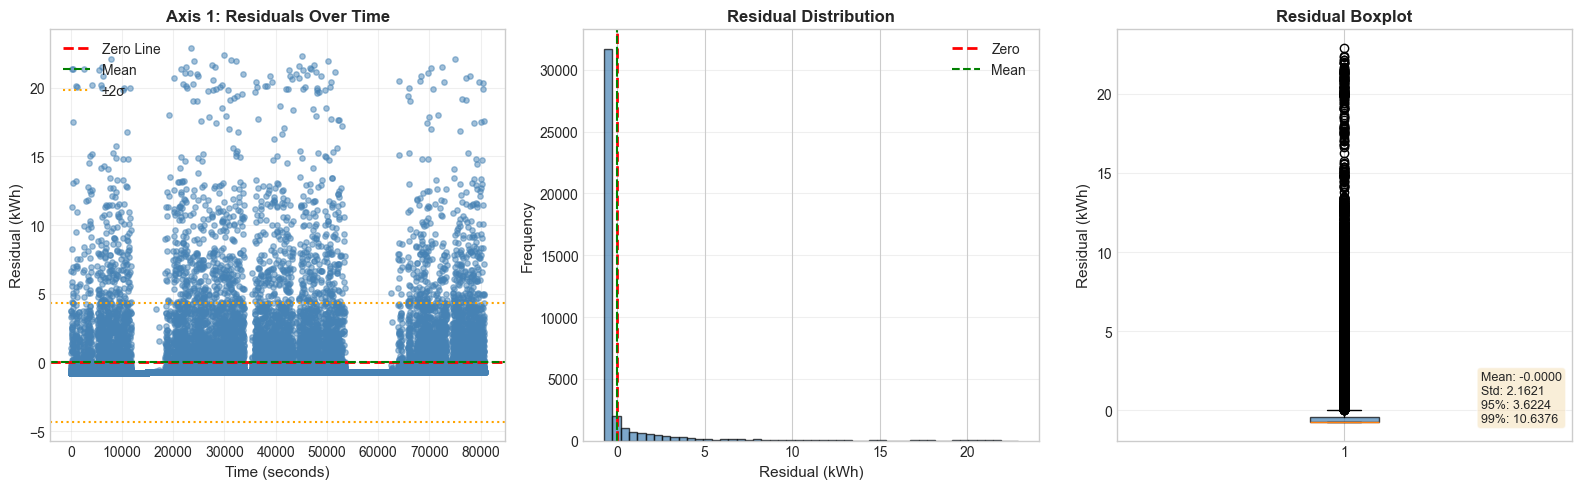


AXIS 2 RESIDUAL ANALYSIS
💾 Saved plot: ../results/residual_analysis/axis_2_residuals.png


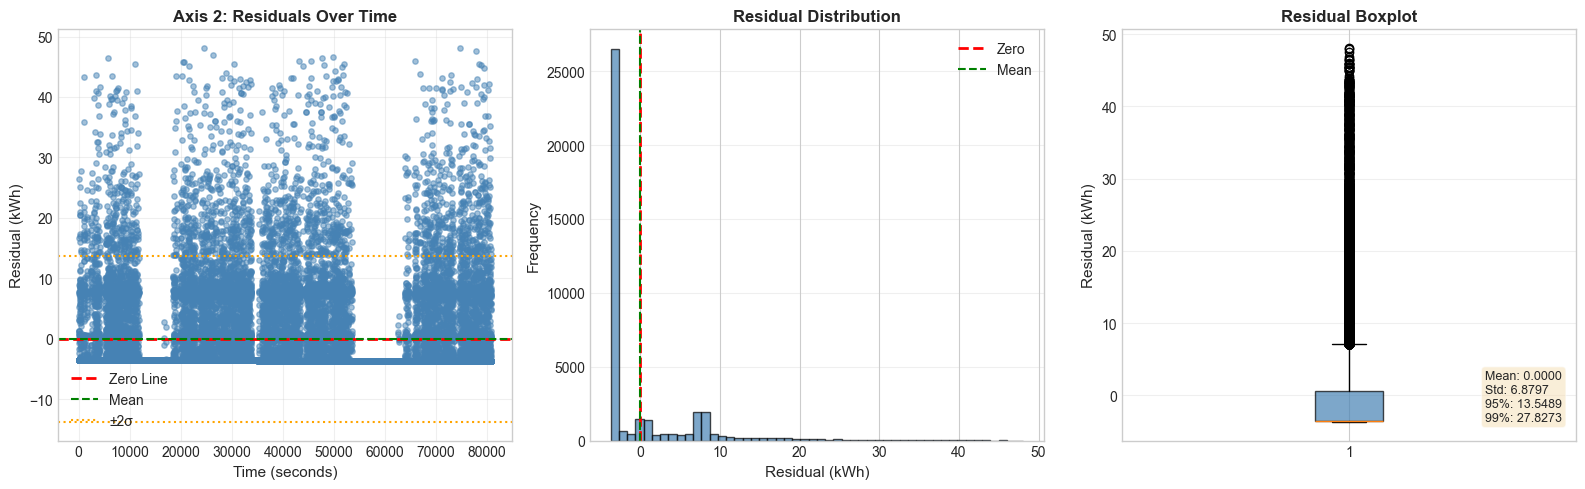


AXIS 3 RESIDUAL ANALYSIS
💾 Saved plot: ../results/residual_analysis/axis_3_residuals.png


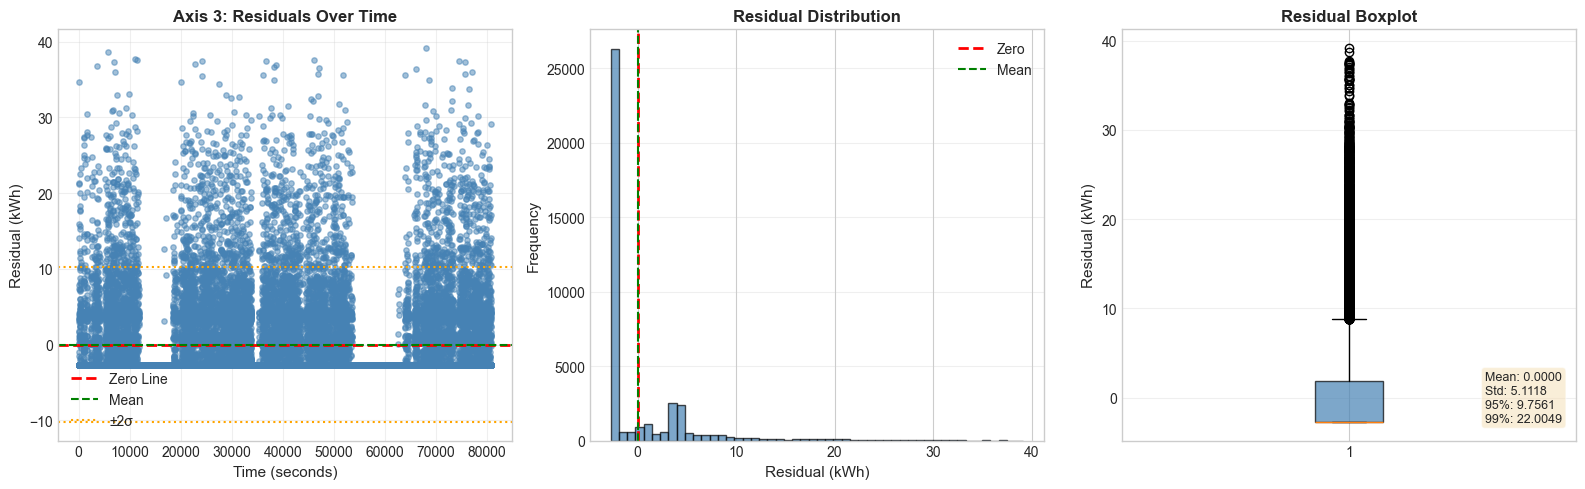


AXIS 4 RESIDUAL ANALYSIS
💾 Saved plot: ../results/residual_analysis/axis_4_residuals.png


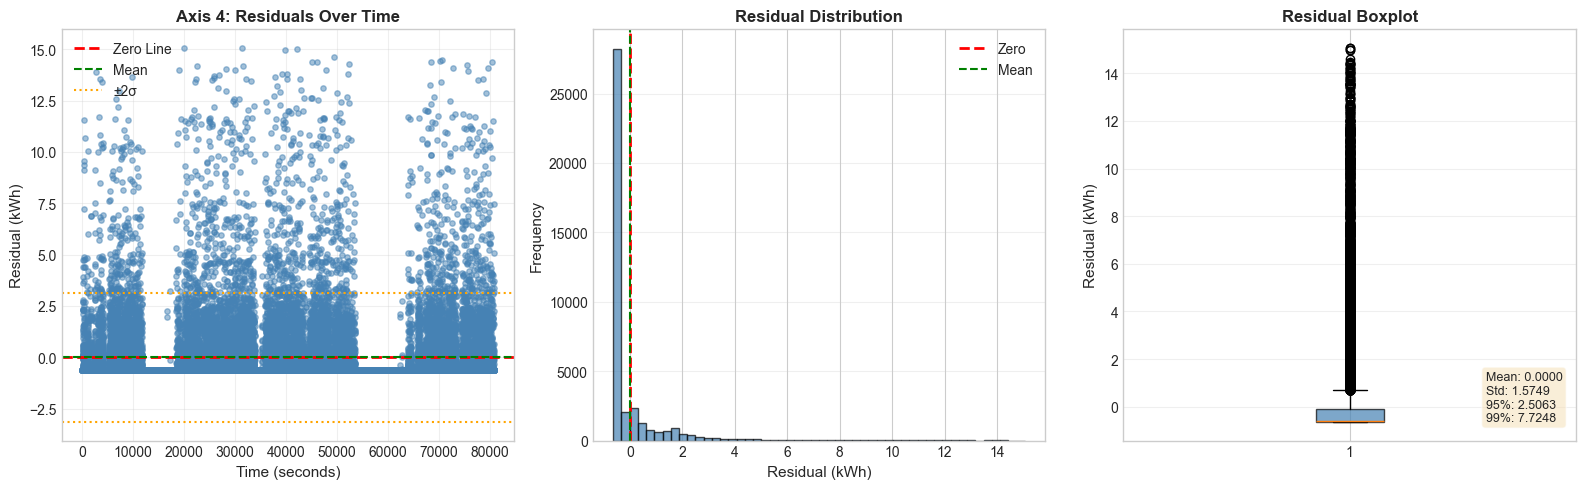


AXIS 5 RESIDUAL ANALYSIS
💾 Saved plot: ../results/residual_analysis/axis_5_residuals.png


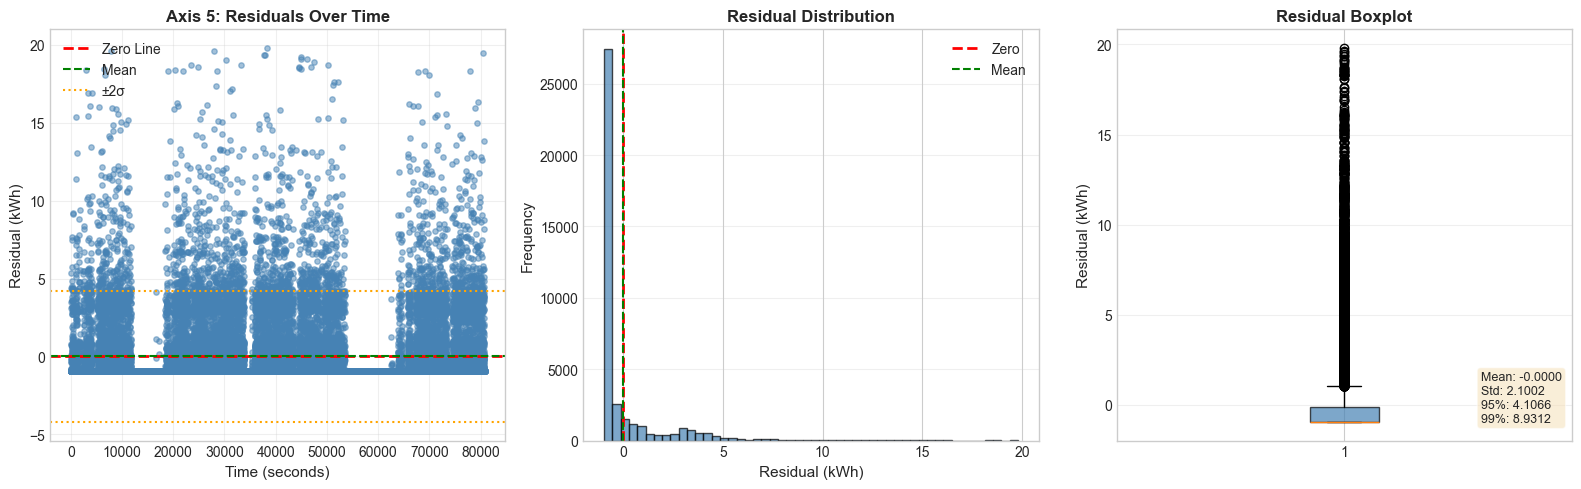


AXIS 6 RESIDUAL ANALYSIS
💾 Saved plot: ../results/residual_analysis/axis_6_residuals.png


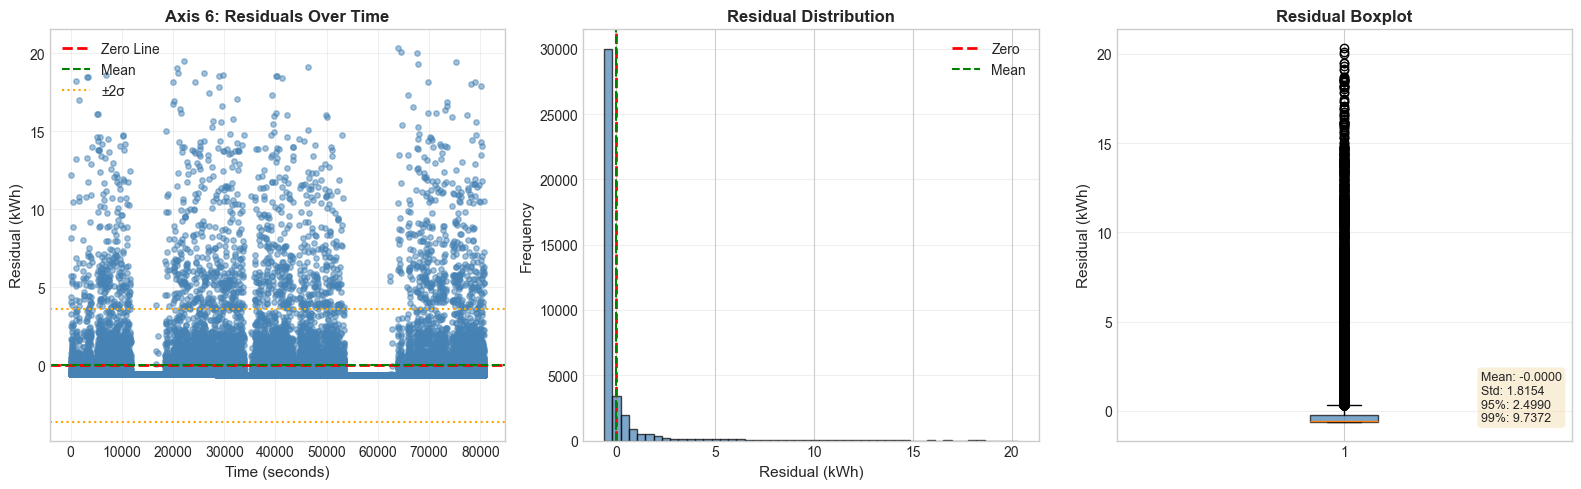


AXIS 7 RESIDUAL ANALYSIS
💾 Saved plot: ../results/residual_analysis/axis_7_residuals.png


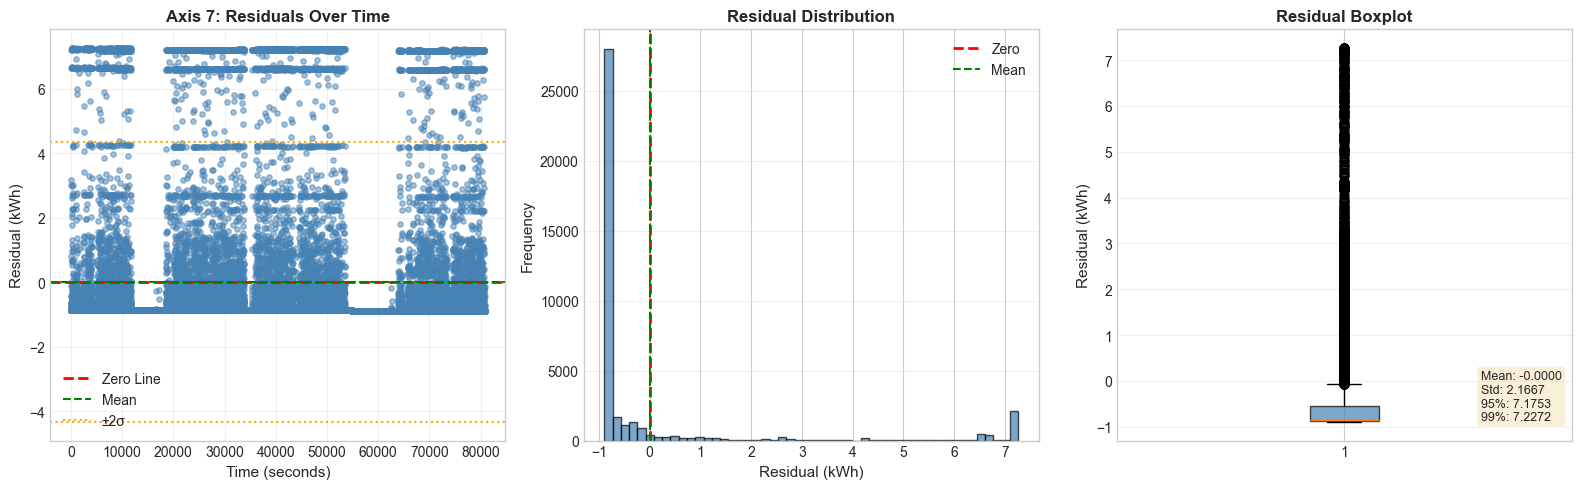


AXIS 8 RESIDUAL ANALYSIS
💾 Saved plot: ../results/residual_analysis/axis_8_residuals.png


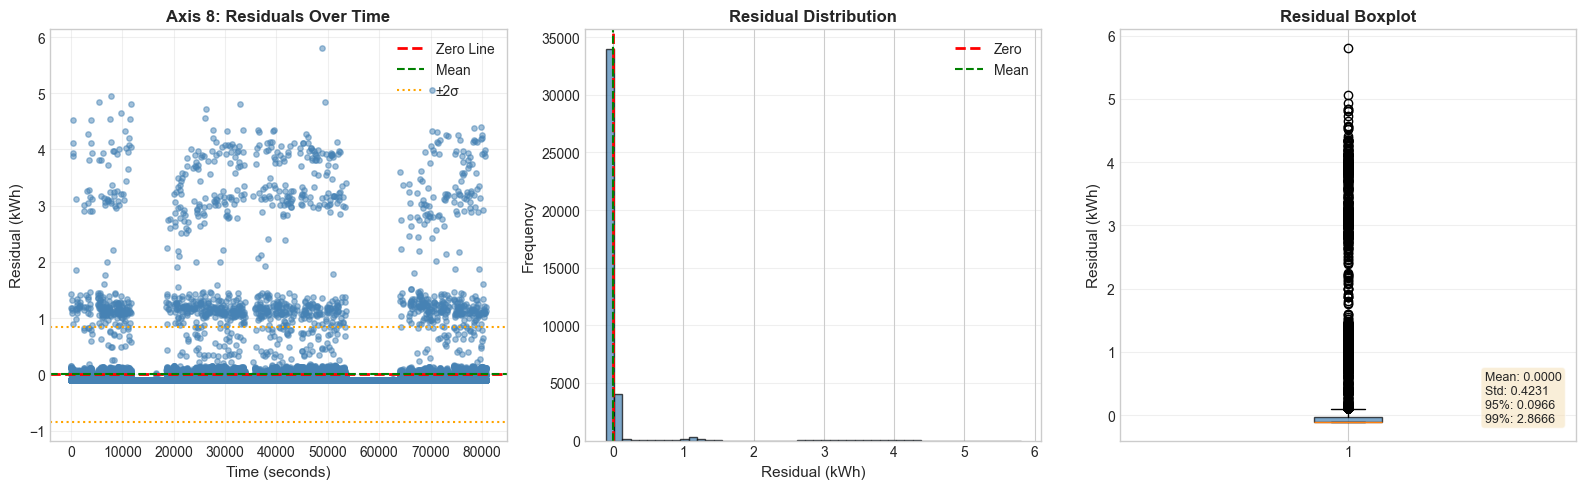

In [10]:
# Analyze residuals for each axis
all_residuals = {}

for axis_num, model in regression_system.models.items():
    axis_col = f'Axis_{axis_num}'
    
    # Calculate residuals
    residuals = model.calculate_residuals(
        training_data['Time'],
        training_data[axis_col]
    )
    all_residuals[axis_num] = residuals
    
    print(f"\n{'='*80}")
    print(f"AXIS {axis_num} RESIDUAL ANALYSIS")
    print(f"{'='*80}")
    
    # Plot residual analysis
    plot_residual_analysis(
        training_data['Time'].values,
        residuals,
        axis_num,
        save_path=f'../results/residual_analysis/axis_{axis_num}_residuals.png'
    )

In [11]:
# Discover thresholds from combined residuals
combined_residuals = np.concatenate(list(all_residuals.values()))

print("\n" + "="*80)
print("COMBINED THRESHOLD DISCOVERY ANALYSIS")
print("="*80)

threshold_suggestions = discover_thresholds_from_residuals(
    combined_residuals,
    percentile_alert=95,
    percentile_error=99
)


COMBINED THRESHOLD DISCOVERY ANALYSIS

📊 Threshold Discovery Analysis:
   Mean residual: 0.0000
   Std residual: 3.4131
   2σ threshold: 6.8263 (15223 outliers, 4.80%)
   3σ threshold: 10.2394 (5848 outliers, 1.84%)
   95th percentile: 6.6238
   99th percentile: 14.6453

💡 Suggested Thresholds:
   MinC (Alert): 6.8263 kWh
   MaxC (Error): 14.6453 kWh


### Threshold Selection & Justification

**FILL IN YOUR ANALYSIS BELOW BASED ON OUTPUT ABOVE:**

#### Analysis Summary
- **Mean residual:** [Fill in]
- **Standard deviation:** [Fill in]
- **95th percentile:** [Fill in]
- **99th percentile:** [Fill in]

#### Selected Thresholds & Justification

Write your justification here explaining WHY you chose these values based on the statistical analysis.

In [12]:
# Set thresholds based on your analysis
MinC = threshold_suggestions['suggested_MinC']
MaxC = threshold_suggestions['suggested_MaxC']
T = 60  # seconds

print(f"\n" + "="*80)
print("SELECTED THRESHOLDS")
print("="*80)
print(f"MinC (Alert): {MinC:.4f} A")
print(f"MaxC (Error): {MaxC:.4f} A")
print(f"T (Time Window): {T} seconds")
print("="*80)


SELECTED THRESHOLDS
MinC (Alert): 6.8263 A
MaxC (Error): 14.6453 A
T (Time Window): 60 seconds


## 5. Generate Synthetic Test Data

In [13]:
# Initialize data generator
data_generator = SyntheticDataGenerator(training_data, time_column='Time')
data_generator.save_statistics('../data/processed/training_statistics.csv')

💾 Statistics saved to ../data/processed/training_statistics.csv


In [14]:
# Generate synthetic test data
test_data = data_generator.generate_test_data(
    n_samples=1000,
    anomaly_rate=0.10,
    extend_time=True,
    random_seed=42
)

print(f"\n📊 Test Data Shape: {test_data.shape}")
display(test_data.head(10))

✅ Generated 1000 synthetic samples
   Normal samples: 900 (90.0%)
   Anomaly samples: 100 (10.0%)
   Time range: 80794.97 - 121192.45

📊 Test Data Shape: (1000, 9)


,Time,Axis_1,Axis_2,Axis_3,Axis_4,Axis_5,Axis_6,Axis_7,Axis_8
0,80794.968000,-1.396396,-5.784349,-3.342311,-0.043664,2.893020,0.760703,4.888352,-0.521089
1,80835.405922,0.179660,-7.498671,-7.607974,-0.115164,-1.218061,0.358696,1.069332,1.218336
2,80875.843844,0.936930,6.513874,5.298190,2.199905,1.809101,0.724591,1.131581,-0.218720
3,80916.281766,0.828225,-5.003045,6.549882,1.919541,0.066565,-0.300850,-1.209263,0.019624
4,80956.719688,1.109954,2.511666,-4.629891,1.218513,0.561716,0.958764,2.406276,-0.033850
5,80997.157610,-1.127534,11.660108,5.246857,0.725365,2.191344,2.094855,1.276876,0.734047
6,81037.595532,4.958122,1.494610,5.296782,0.611731,-1.671370,1.257209,0.754036,0.859256
7,81078.033453,2.322396,-2.732773,6.398467,-1.065471,3.465194,-0.454401,2.973874,0.023256
8,81118.471375,3.684888,17.882983,-6.650295,4.259125,3.350537,-0.070144,4.298841,0.263753
9,81158.909297,2.096352,-10.004133,14.508175,1.385683,0.394584,0.635197,1.275738,0.661979


In [15]:
# Save test data
test_data.to_csv('../data/processed/synthetic_test_data.csv', index=False)
print("\n💾 Test data saved")


💾 Test data saved


## 6. Anomaly Detection

In [16]:
# Initialize anomaly detector
detector = AnomalyDetector(MinC=MinC, MaxC=MaxC, T=T)

🚨 Anomaly Detector Initialized:
   Alert Threshold (MinC): 6.8263 kWh
   Error Threshold (MaxC): 14.6453 kWh
   Time Window (T): 60.0 seconds


In [17]:
# Detect anomalies across all axes
events_df = detector.detect_all_axes(
    test_data,
    regression_system.models,
    time_column='Time'
)

if len(events_df) > 0:
    print("\n📋 Detected Anomalies:\n")
    display(events_df)
    
    events_df.to_csv('../data/results/alerts_log.csv', index=False)
    print("\n💾 Anomaly log saved")
else:
    print("\n⚠️  No anomalies detected.")


🔍 Detecting anomalies across all axes...

Axis 1: 0 alerts, 0 errors
Axis 2: 17 alerts, 10 errors
Axis 3: 15 alerts, 3 errors
Axis 4: 0 alerts, 0 errors
Axis 5: 1 alerts, 0 errors
Axis 6: 0 alerts, 0 errors
Axis 7: 0 alerts, 0 errors
Axis 8: 0 alerts, 0 errors

✅ Total Anomalies Detected: 46
   Alerts: 33
   Errors: 13

📋 Detected Anomalies:



,axis,type,start_time,end_time,duration,max_deviation,mean_deviation
0,2,ALERT,81361.098907,81441.974751,121.313766,14.642826,10.063530
1,2,ERROR,84070.439676,84110.877598,80.875844,19.812533,19.460524
2,3,ALERT,84353.505129,84393.943051,80.875844,8.425957,7.690020
3,3,ALERT,86537.152913,86577.590835,80.875844,10.888077,9.621323
4,3,ALERT,86658.466679,86698.904601,80.875844,10.521115,8.756452
5,3,ALERT,87062.845898,87103.283820,80.875844,10.011627,8.912504
6,2,ERROR,88154.669790,88195.107712,80.875844,20.125337,18.005942
7,2,ERROR,88478.173165,88518.611087,80.875844,19.279140,18.253767
8,3,ERROR,89367.807447,89408.245369,80.875844,17.110014,16.858226
9,3,ALERT,90297.879652,90338.317574,80.875844,10.526497,10.516781



💾 Anomaly log saved


## 7. Visualization

💾 Saved plot: ../results/alerts_visualization/axis_1_alerts.png


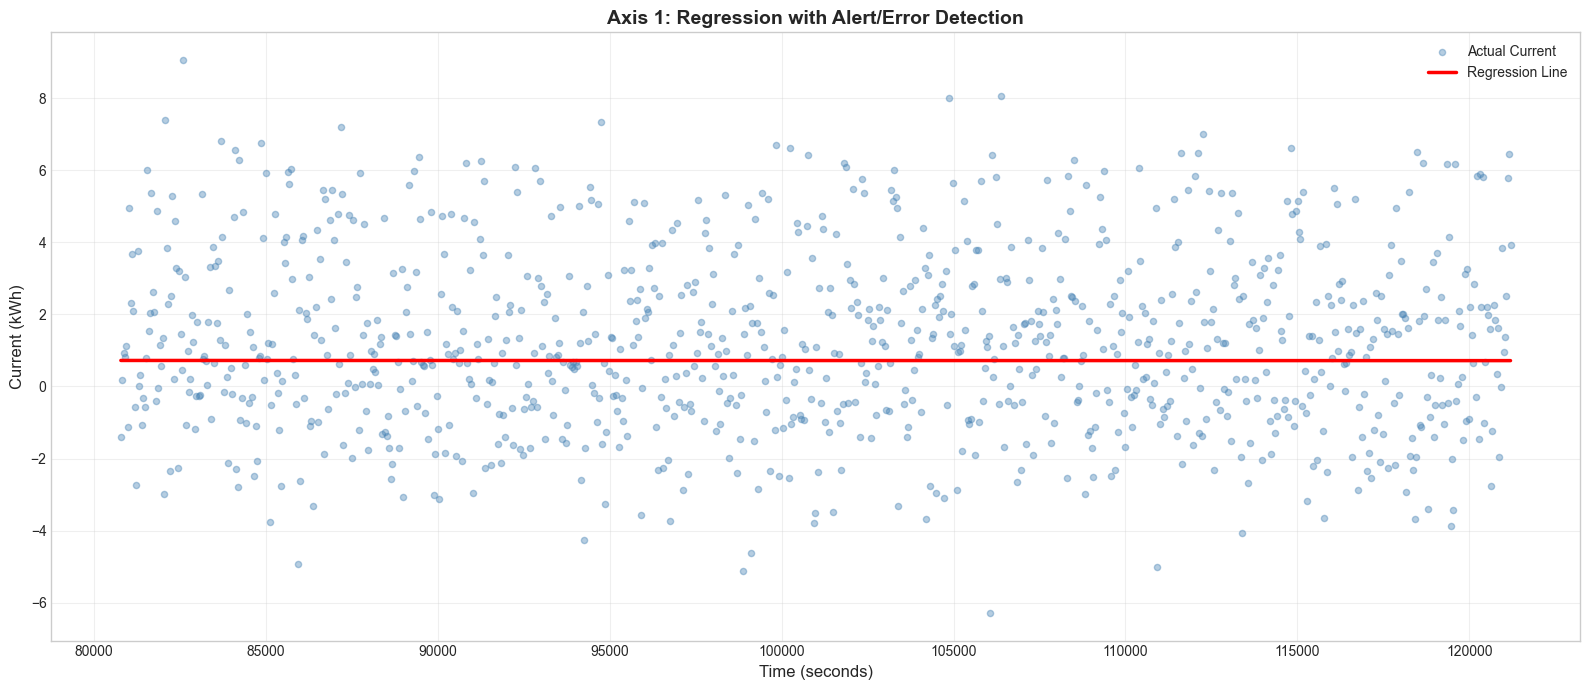

💾 Saved plot: ../results/alerts_visualization/axis_2_alerts.png


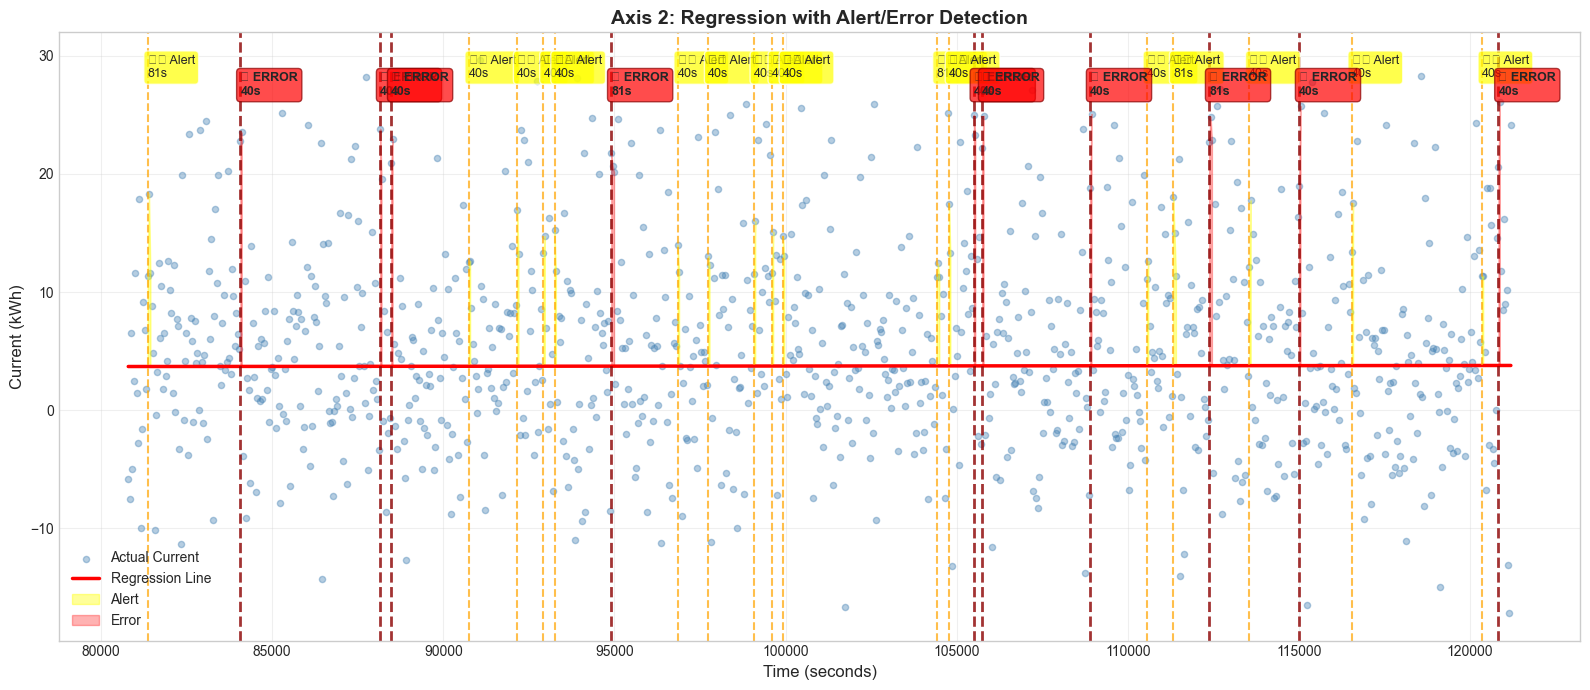

💾 Saved plot: ../results/alerts_visualization/axis_3_alerts.png


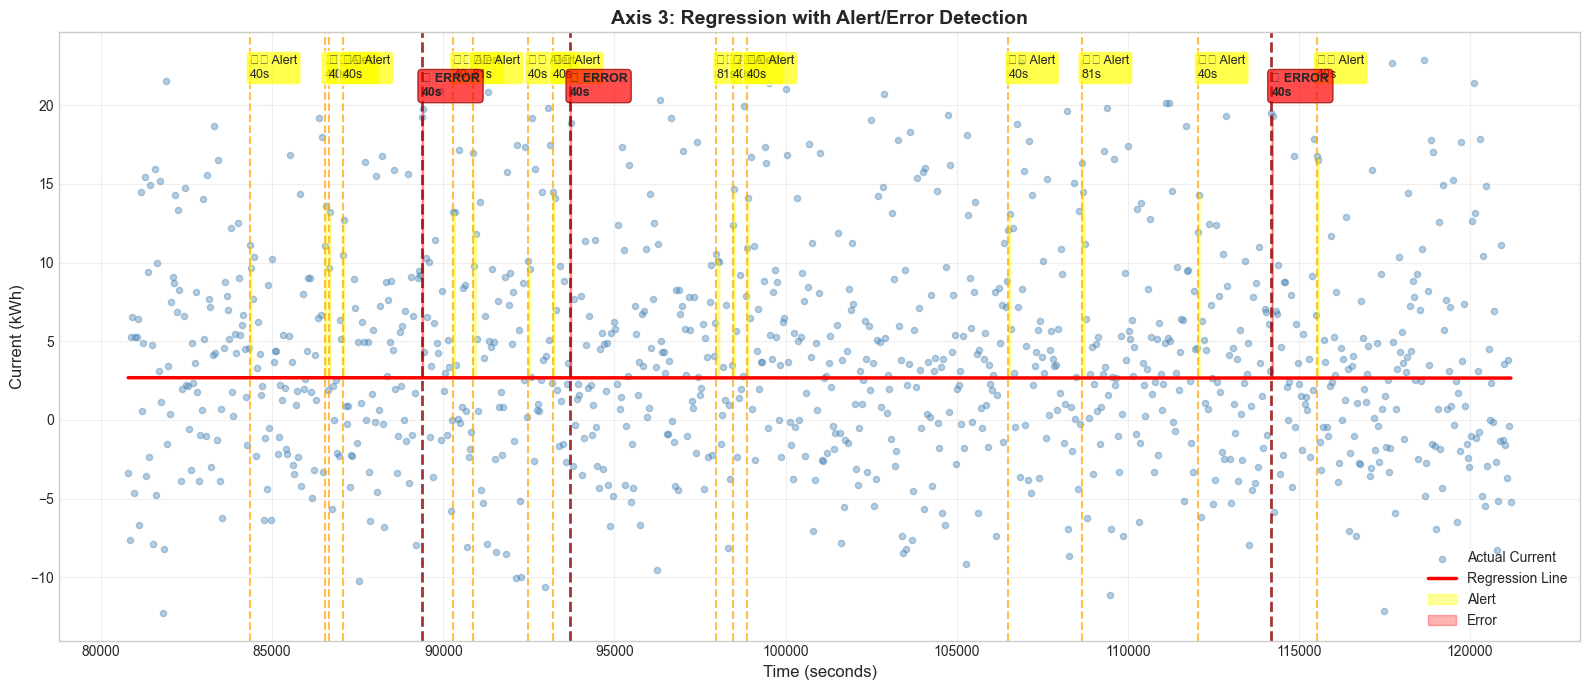

💾 Saved plot: ../results/alerts_visualization/axis_4_alerts.png


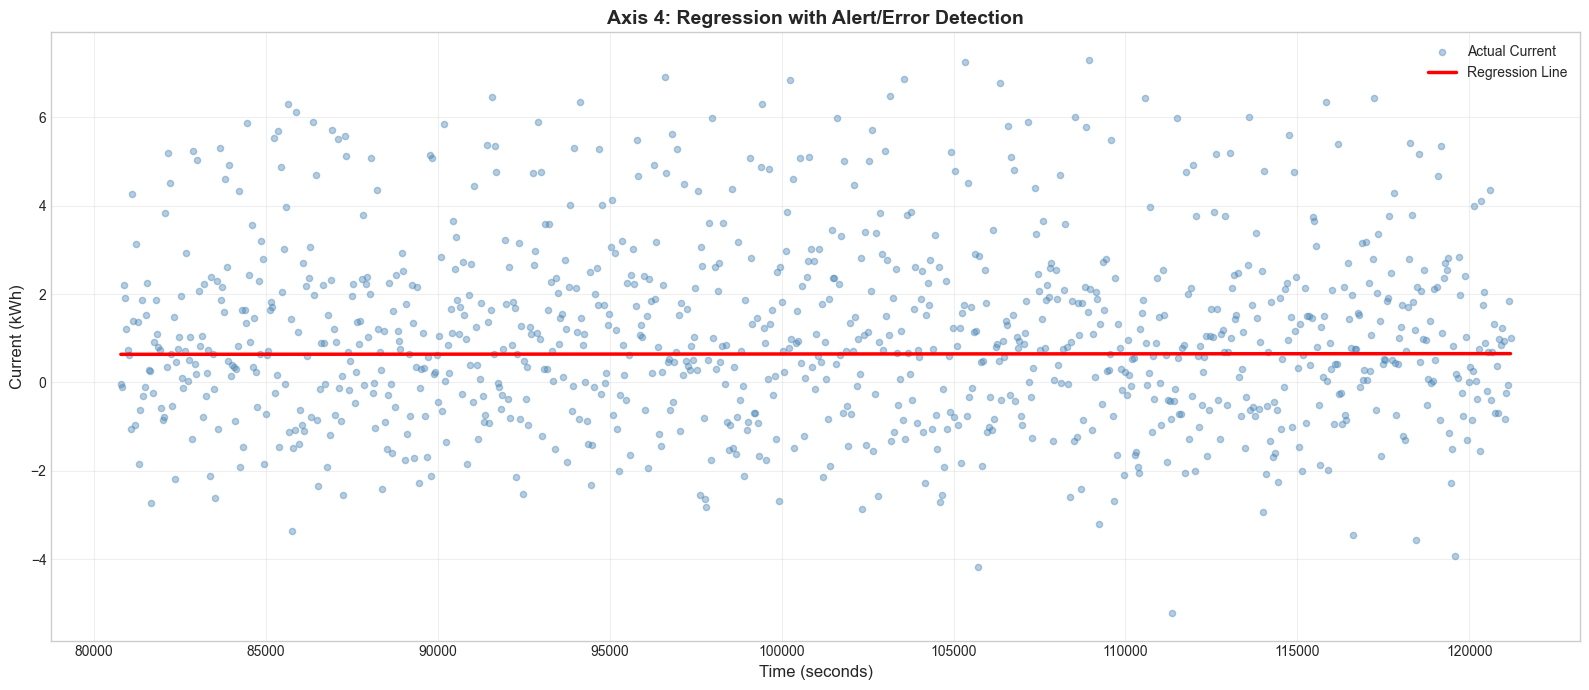

💾 Saved plot: ../results/alerts_visualization/axis_5_alerts.png


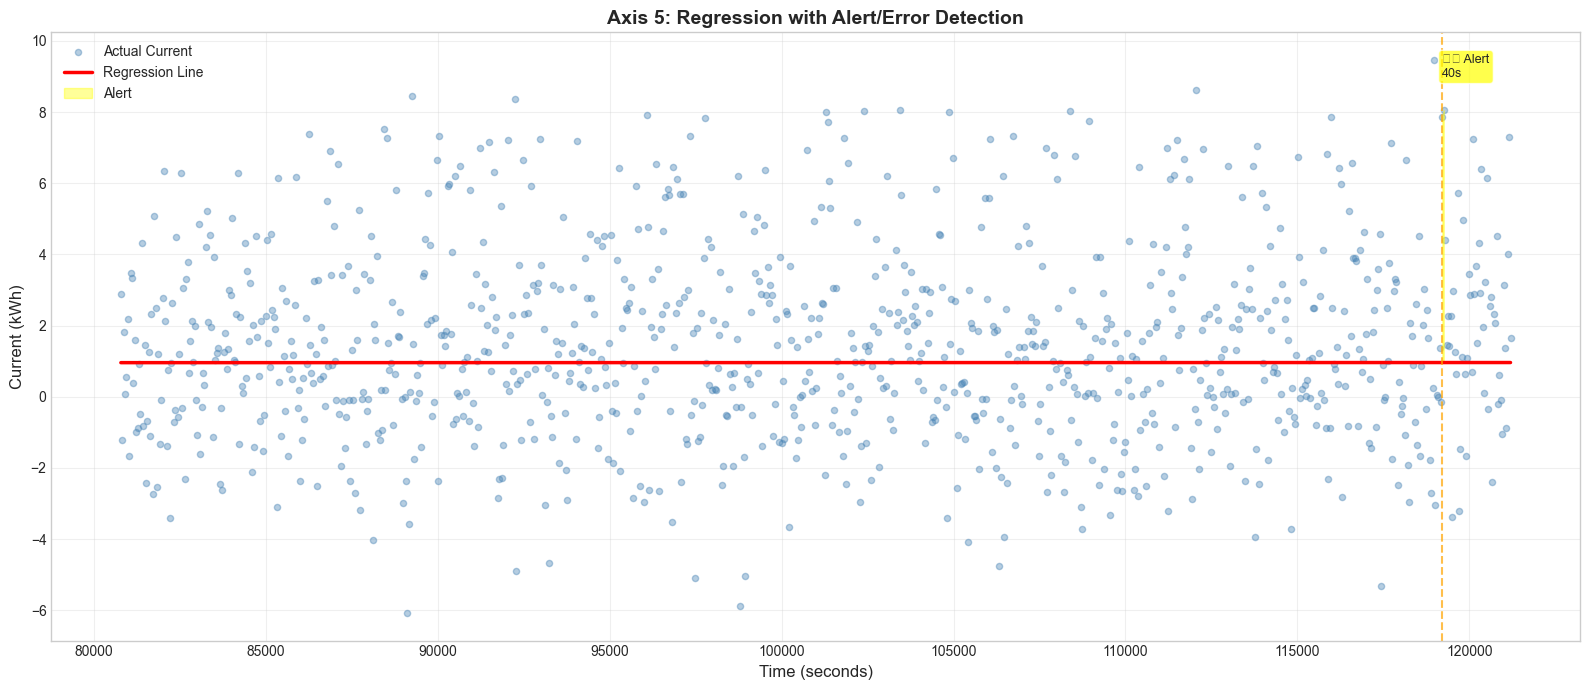

💾 Saved plot: ../results/alerts_visualization/axis_6_alerts.png


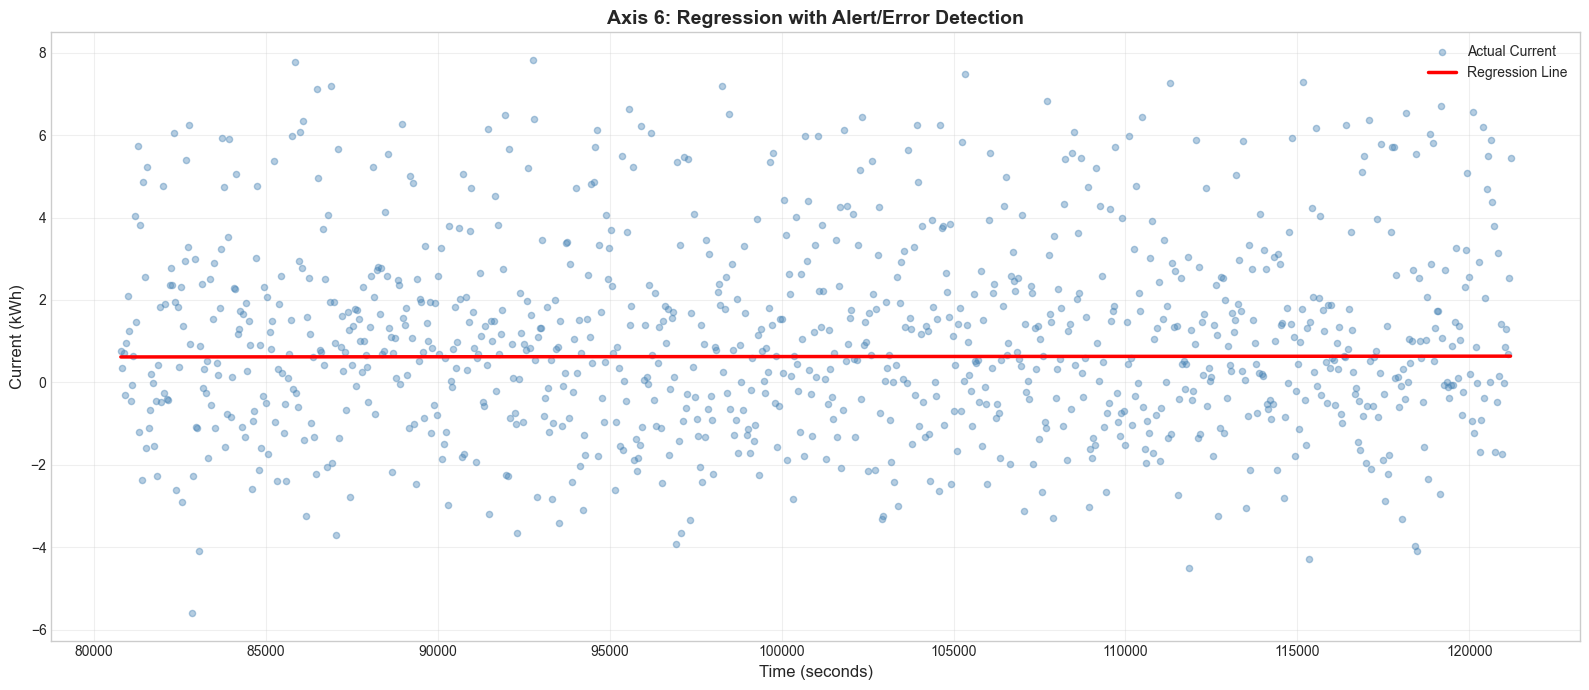

💾 Saved plot: ../results/alerts_visualization/axis_7_alerts.png


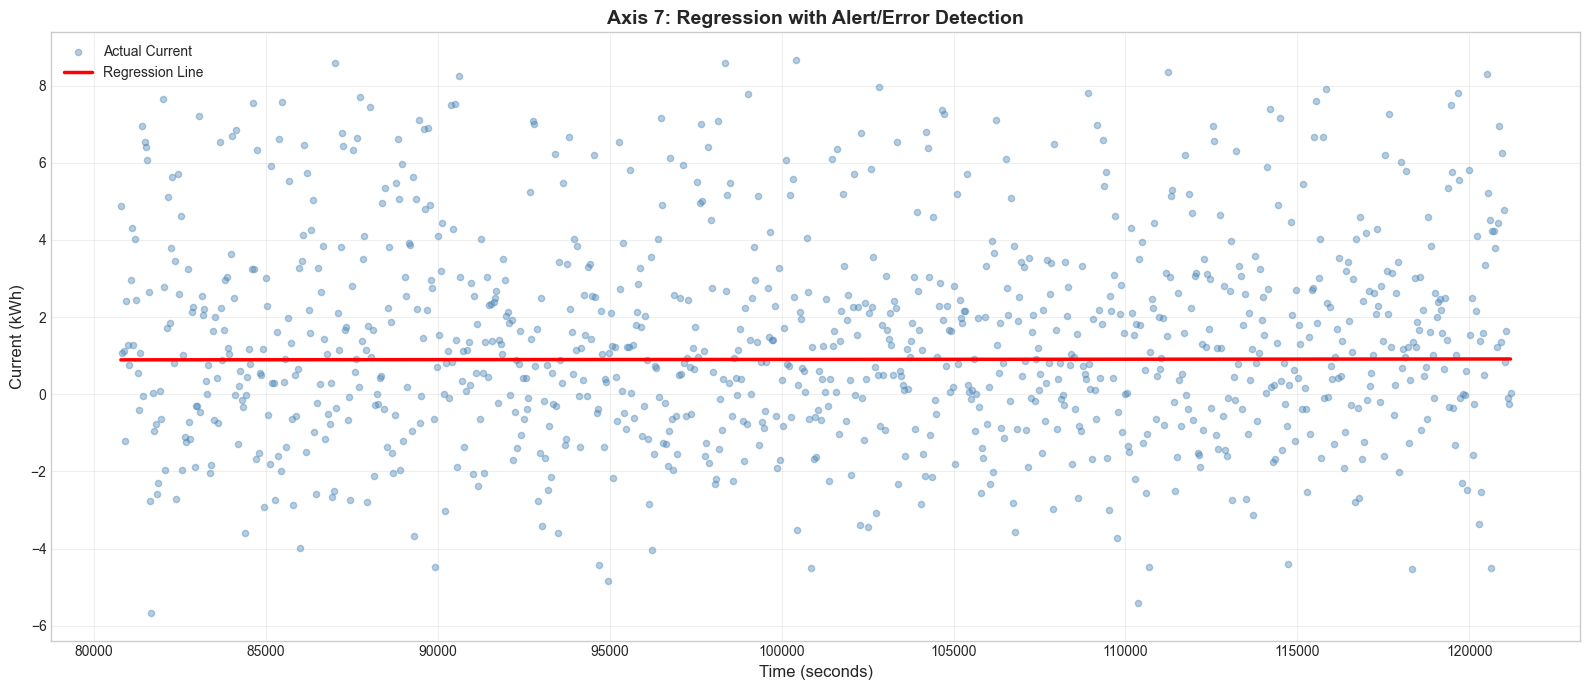

💾 Saved plot: ../results/alerts_visualization/axis_8_alerts.png


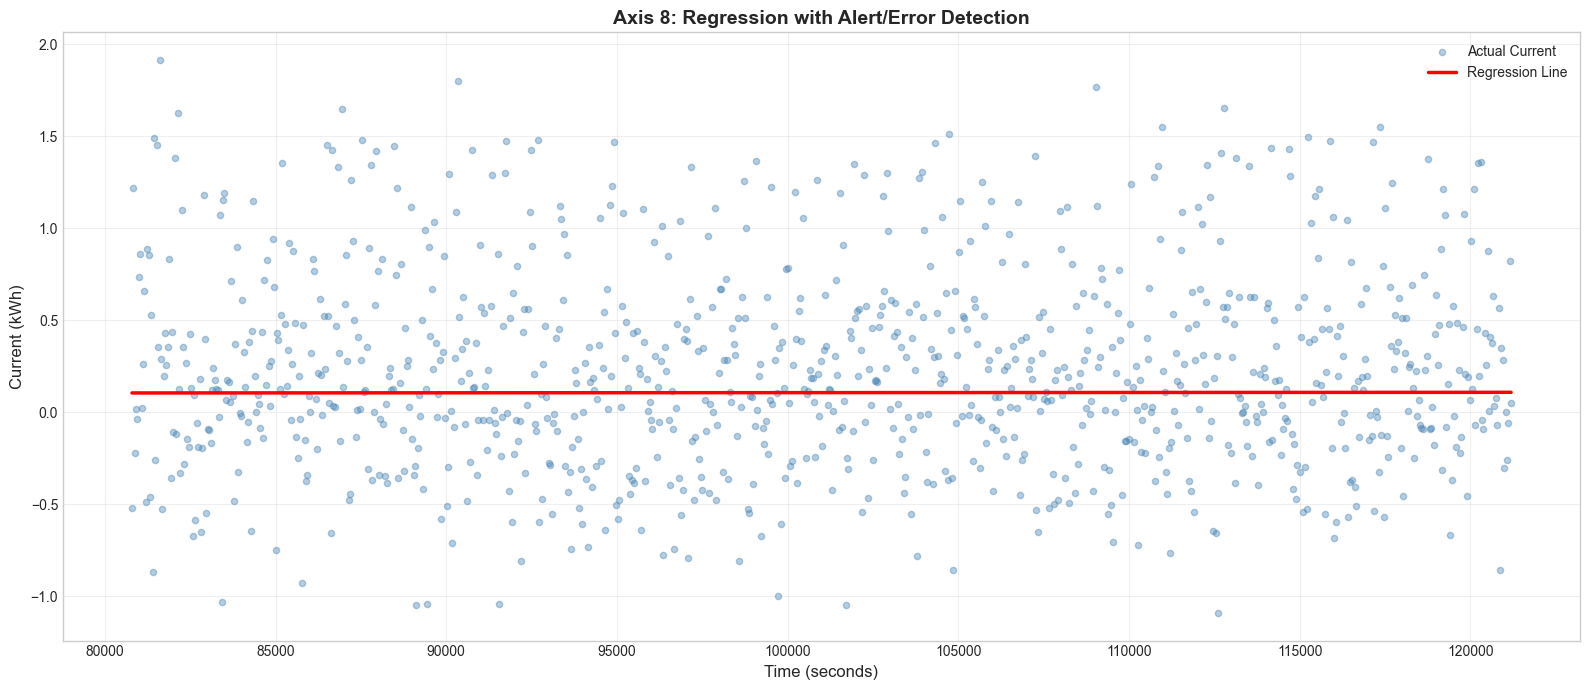

In [18]:
import os
import numpy as np

os.makedirs('../results/alerts_visualization', exist_ok=True)

for axis_num, model in regression_system.models.items():
    axis_col = f'Axis_{axis_num}'

    if axis_col not in test_data.columns:
        print(f"⚠️ Axis {axis_num} column missing — skipping")
        continue

    # Prepare regression data
    time = test_data['Time'].values.reshape(-1, 1)
    actual = test_data[axis_col].values
    predicted = model.predict(time)

    alerts, errors = [], []

    # Build alert/error dictionaries EXACTLY as visualization expects
    if (
        len(events_df) > 0
        and {'axis', 'type', 'start_time', 'end_time'}.issubset(events_df.columns)
    ):
        axis_events = events_df[events_df['axis'] == axis_num]

        for _, row in axis_events.iterrows():
            start_idx = np.searchsorted(time.flatten(), row['start_time'])
            end_idx = np.searchsorted(time.flatten(), row['end_time'])

            # Clamp indices
            start_idx = max(0, min(start_idx, len(time) - 1))
            end_idx = max(0, min(end_idx, len(time) - 1))

            duration = row['end_time'] - row['start_time']

            event_dict = {
                'start_idx': start_idx,
                'end_idx': end_idx,
                'duration': duration
            }

            if row['type'] == 'ALERT':
                alerts.append(event_dict)
            elif row['type'] == 'ERROR':
                errors.append(event_dict)

    # Plot
    plot_regression_with_alerts(
        time.flatten(),
        actual,
        predicted,
        alerts,
        errors,
        axis_num,
        save_path=f'../results/alerts_visualization/axis_{axis_num}_alerts.png'
    )

💾 Saved plot: ../results/regression_plots/all_axes_comparison.png


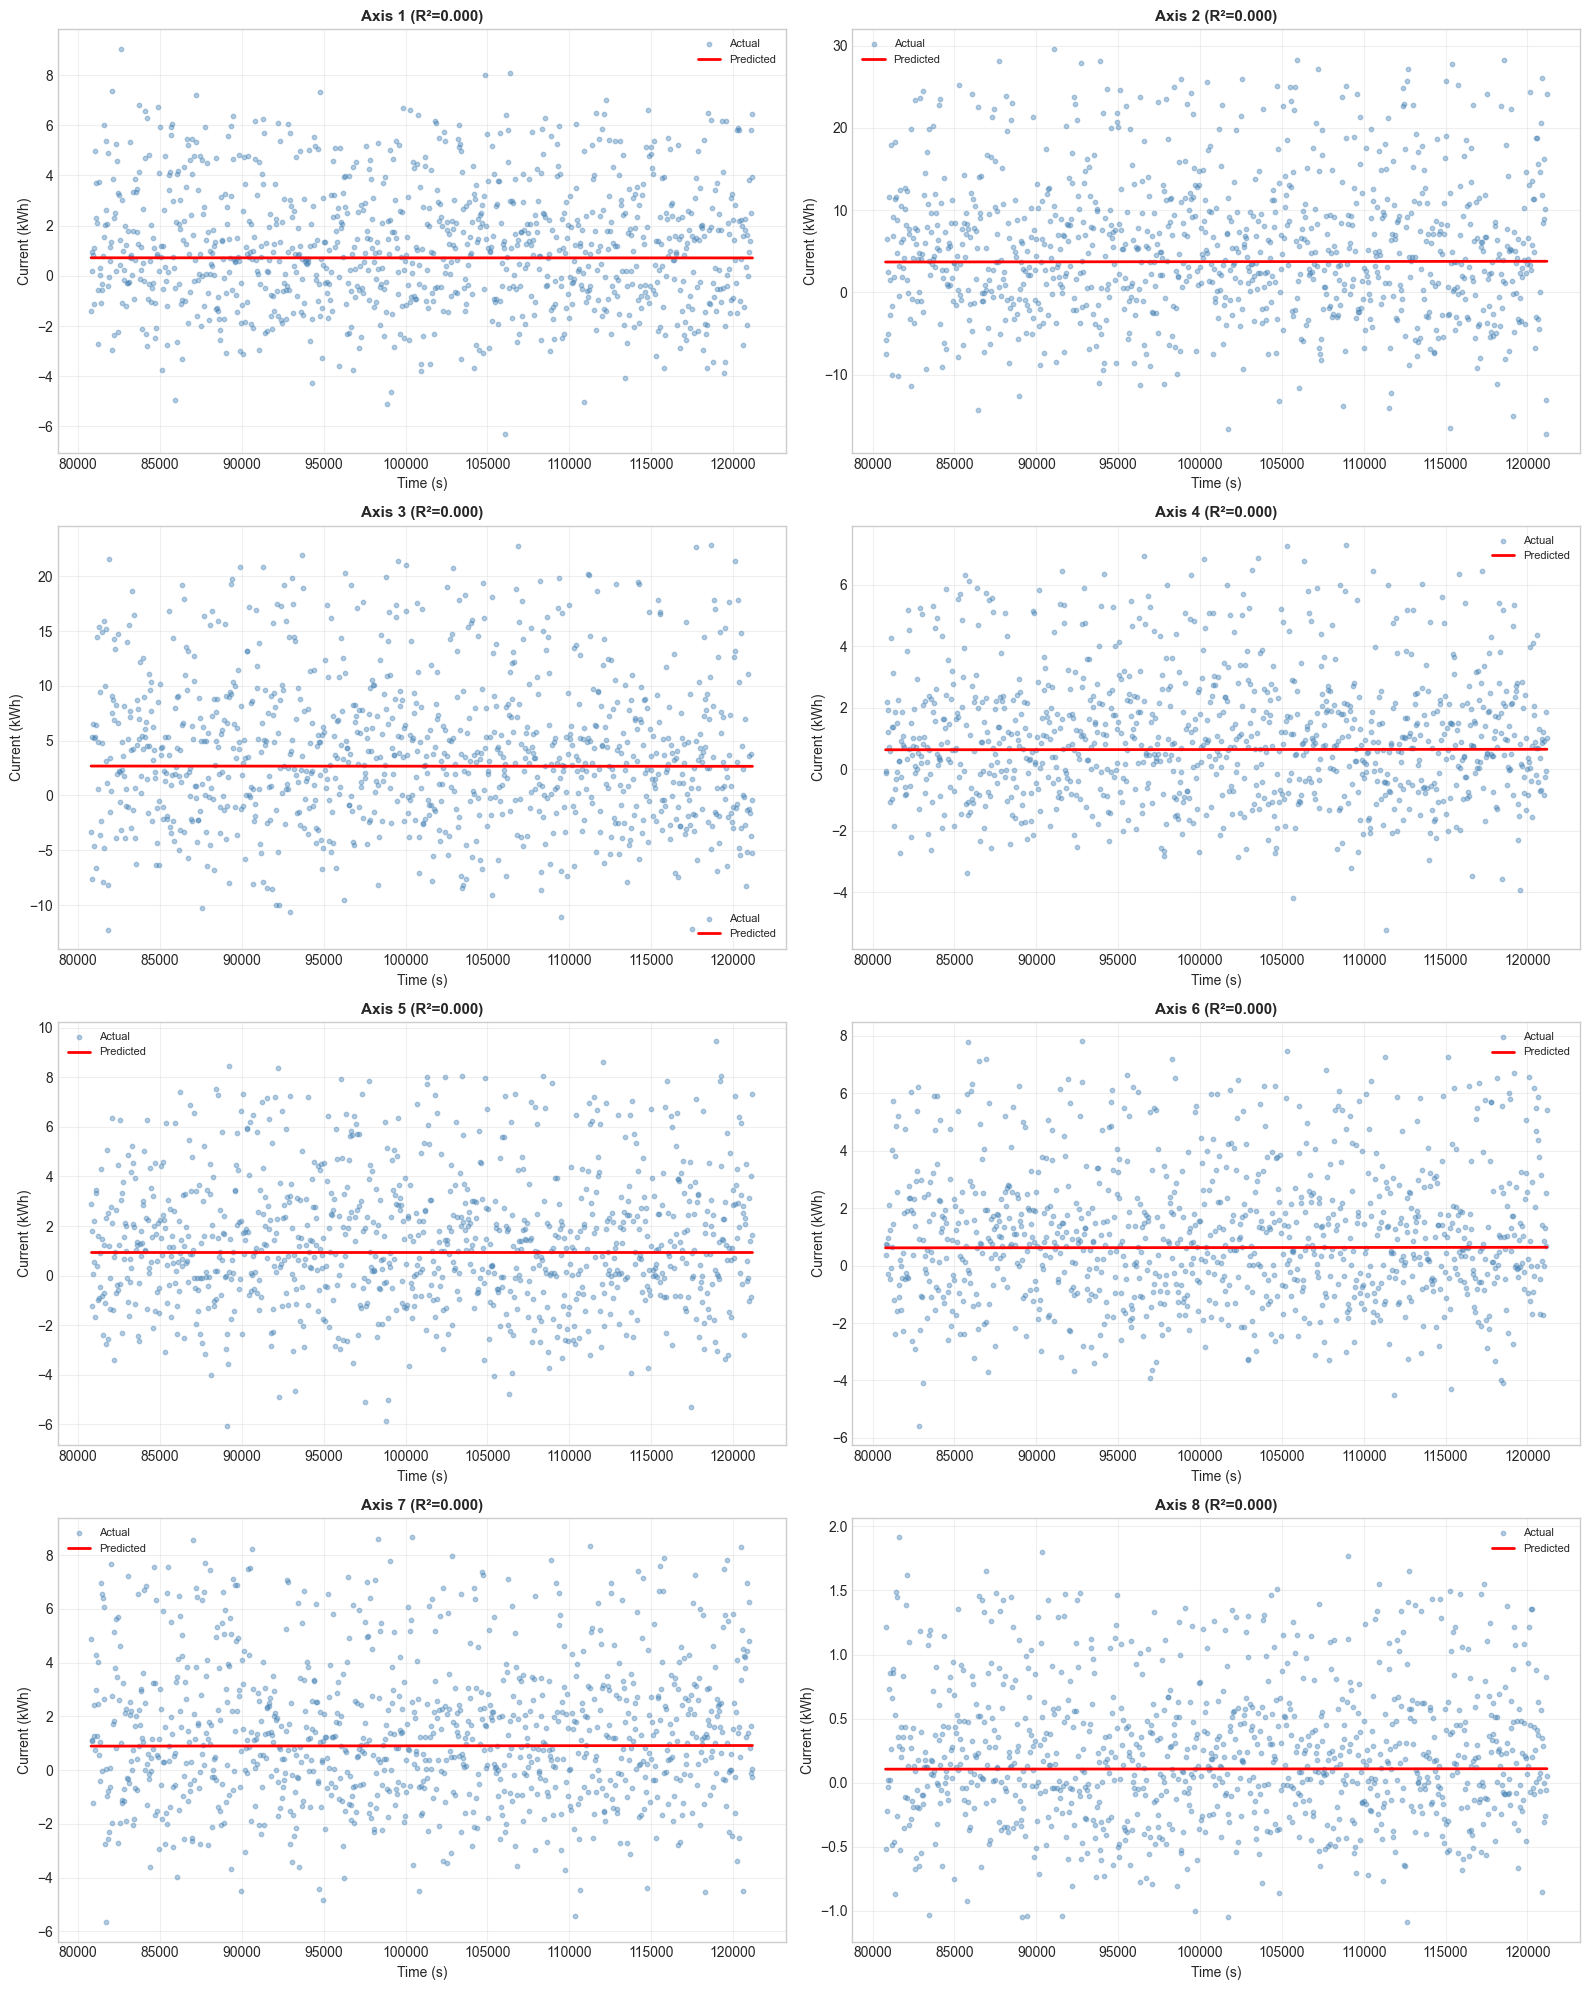

In [19]:
# Plot all axes comparison
plot_all_axes_comparison(
    regression_system.models,
    test_data,
    time_column='Time',
    save_path='../results/regression_plots/all_axes_comparison.png'
)

💾 Saved plot: ../results/alerts_visualization/anomaly_summary.png


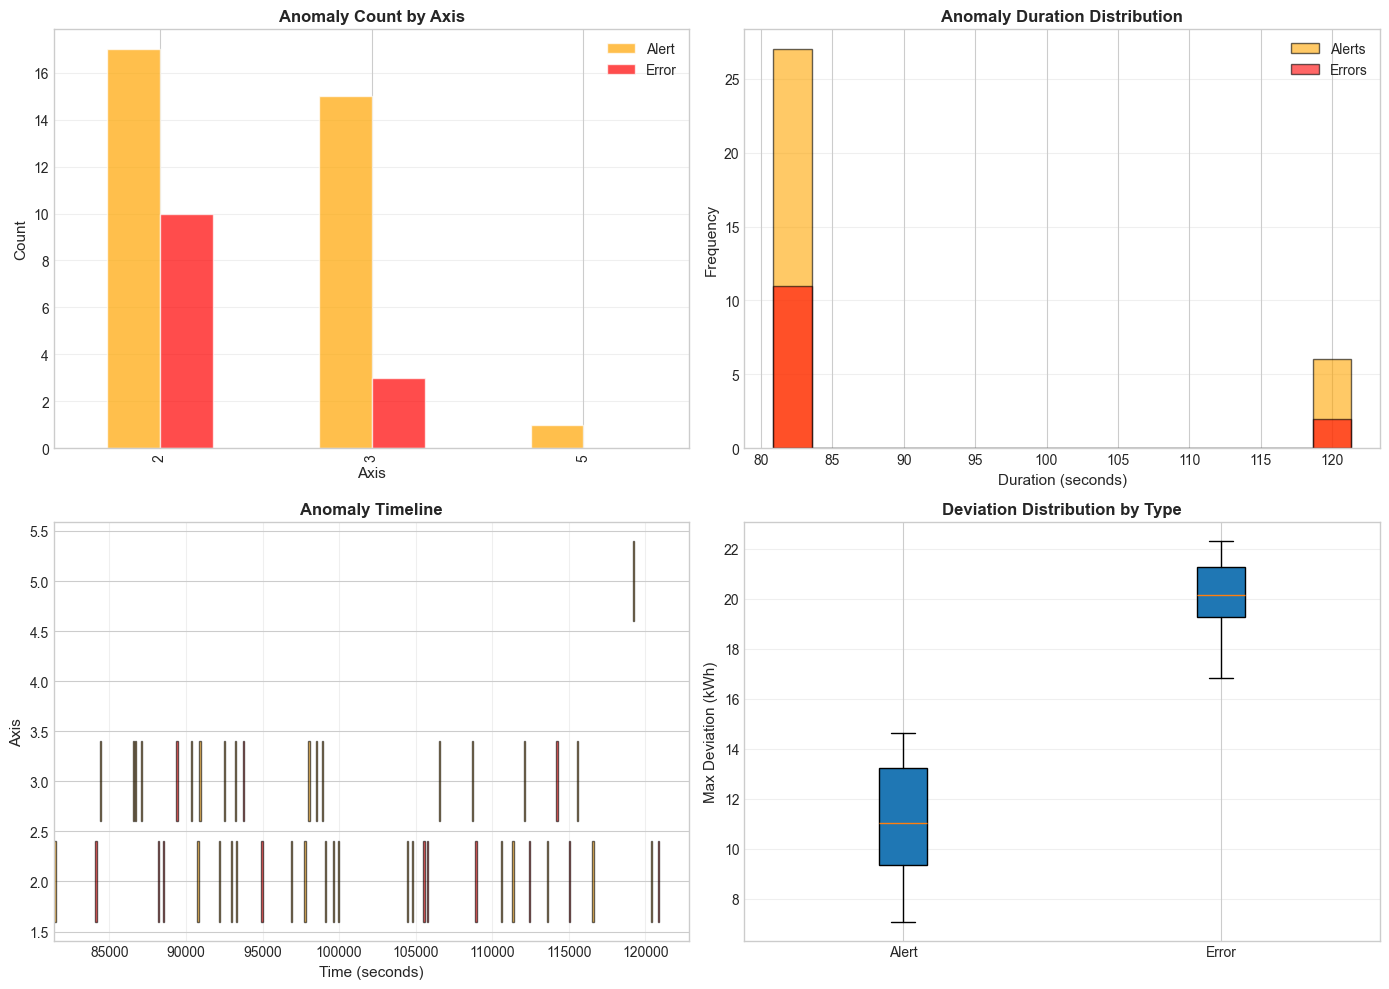

In [20]:
# Plot anomaly summary
if len(events_df) > 0:
    plot_anomaly_summary(
        events_df,
        save_path='../results/alerts_visualization/anomaly_summary.png'
    )

## 8. Results Summary

In [21]:
# Create text summary report
thresholds_dict = {'MinC': MinC, 'MaxC': MaxC, 'T': T}

create_results_summary_report(
    regression_system.models,
    events_df if len(events_df) > 0 else pd.DataFrame(),
    thresholds_dict,
    output_path='../results/summary_report.txt'
)

print("\n✅ Summary report generated!")

📄 Summary report saved to ../results/summary_report.txt

✅ Summary report generated!


## 9. PREDICTIVE DASHBOARD - 2 Week Ahead Forecasting 🎯

**NEW REQUIREMENT:** Create interactive dashboard that predicts failures 2 weeks ahead with pop-up alerts.

This section implements:
- Trend analysis and forecasting
- 2-week ahead failure prediction
- Time-to-failure estimation
- Automatic alert pop-ups
- Severity classification (CRITICAL/WARNING/ALERT)

In [22]:
# Import predictive dashboard
from predictive_dashboard import PredictiveMaintenanceDashboard

print("✅ Predictive dashboard module loaded")

✅ Predictive dashboard module loaded


In [23]:
# Initialize predictive dashboard
dashboard = PredictiveMaintenanceDashboard(
    models=regression_system.models,
    detector=detector,
    forecast_days=14  # 2 weeks ahead prediction
)

print("\n🎯 Predictive Dashboard Initialized!")
print("   Forecasting 2 weeks (14 days) ahead")
print("   Will generate alerts for predicted failures")

🎯 Predictive Dashboard Initialized
   Forecast horizon: 14 days (336 hours)
   Alert threshold: 6.8263 A
   Error threshold: 14.6453 A

🎯 Predictive Dashboard Initialized!
   Forecasting 2 weeks (14 days) ahead
   Will generate alerts for predicted failures



📊 Generating predictive dashboard...
   This may take a minute...


💾 Dashboard saved to ../results/predictive_dashboard.png


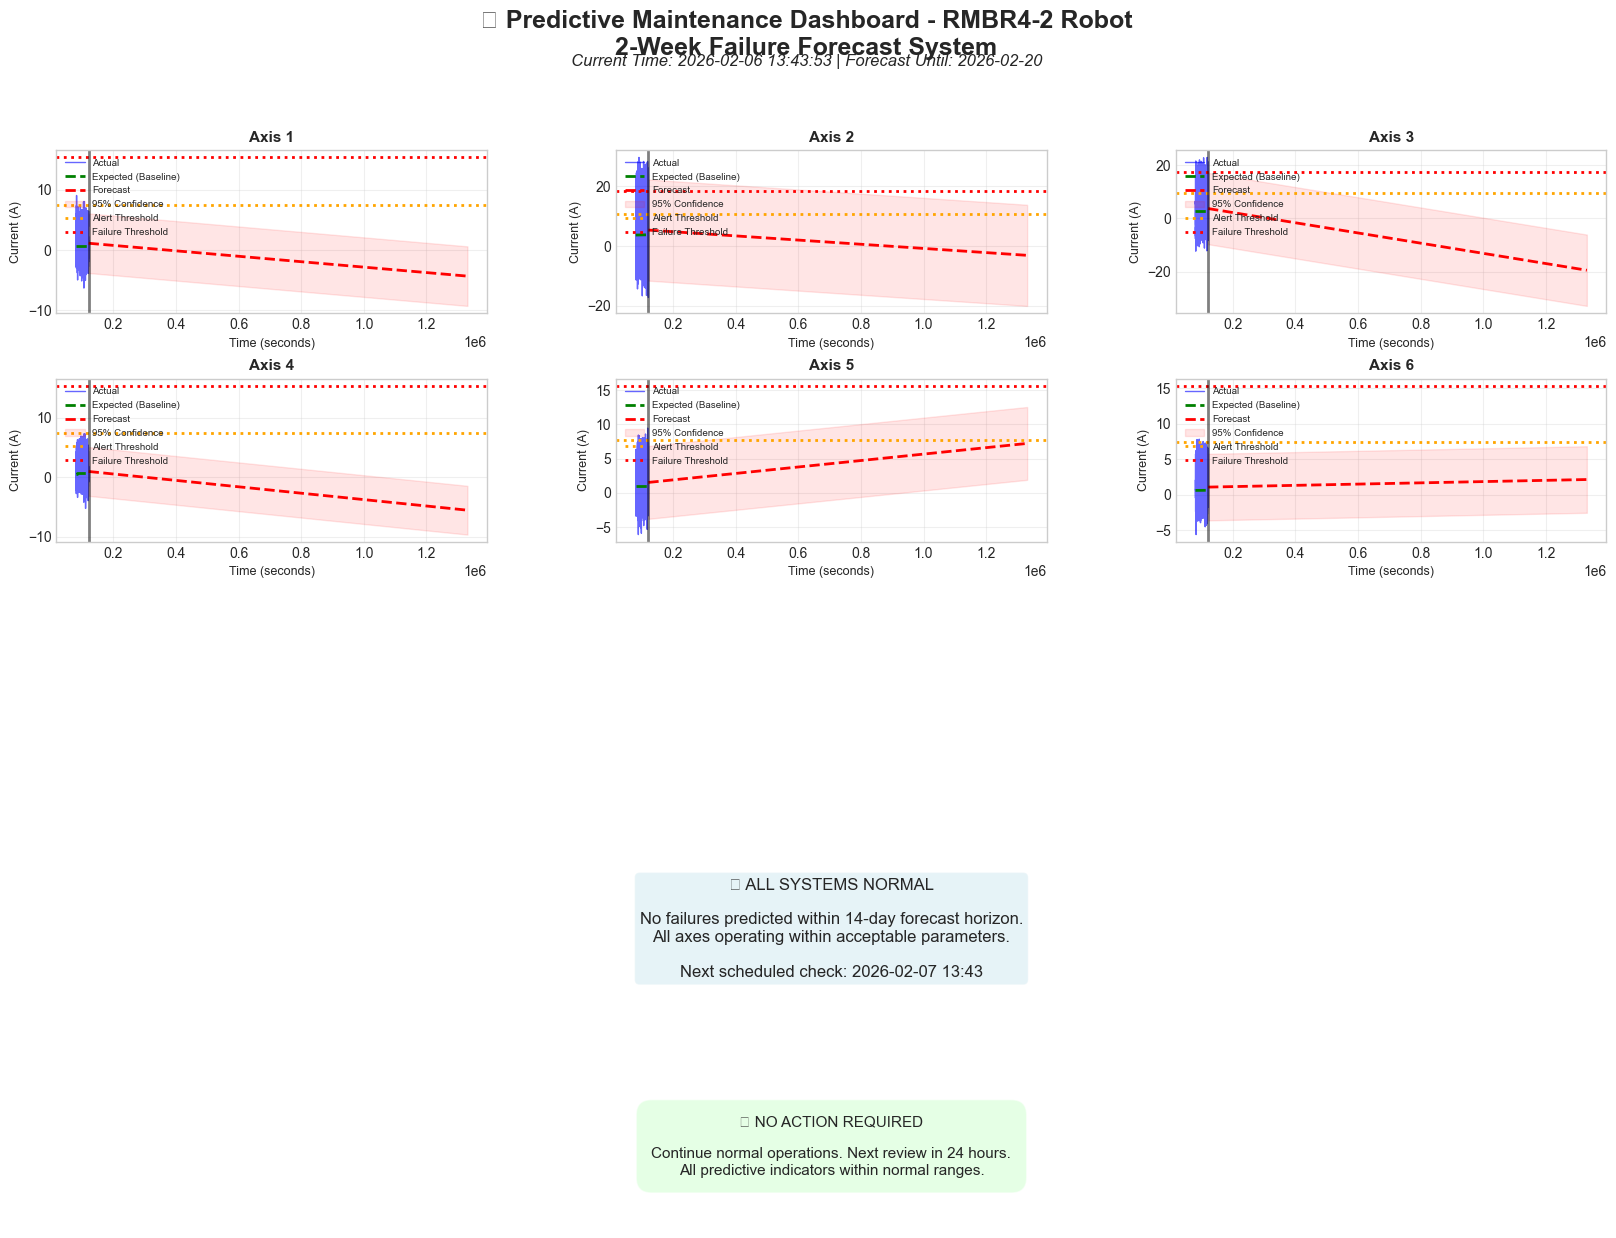


📋 PREDICTION SUMMARY

✅ No failures predicted within 14-day forecast horizon
   All systems operating normally


In [24]:
# Create comprehensive dashboard with 2-week forecast
print("\n📊 Generating predictive dashboard...")
print("   This may take a minute...\n")

predictions = dashboard.create_dashboard(
    test_data,
    save_path='../results/predictive_dashboard.png'
)

print(f"\n{'='*80}")
print(f"📋 PREDICTION SUMMARY")
print(f"{'='*80}")

if predictions:
    print(f"\n⚠️  Found {len(predictions)} predicted failure(s):\n")
    for pred in predictions:
        severity_emoji = '🔴' if pred['severity'] == 'CRITICAL' else '🟡' if pred['severity'] == 'WARNING' else '🟠'
        print(f"{severity_emoji} Axis {pred['axis']}: {pred['time_to_failure_days']:.1f} days until {pred['severity']}")
        print(f"   Current deviation: {pred['current_deviation']:.3f} A")
        print(f"   Predicted peak: {pred['predicted_peak_deviation']:.3f} A\n")
else:
    print("\n✅ No failures predicted within 14-day forecast horizon")
    print("   All systems operating normally")

print("="*80)

In [25]:
# Generate alert pop-up
if predictions:
    print("\n🚨 Generating alert pop-up...")
    dashboard.generate_alert_popup(
        predictions,
        save_path='../results/alert_popup.png'
    )
    
    print("\n✅ Alert pop-up generated!")
    print("   This shows what operators will see when failure is predicted")
    
    # Save predictions to CSV
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv('../results/failure_predictions.csv', index=False)
    print("   Predictions saved to results/failure_predictions.csv")
else:
    print("\n✅ No alerts needed - all systems normal")


✅ No alerts needed - all systems normal


### How the 2-Week Prediction Works

#### Methodology:

1. **Trend Analysis:**
   - Analyzes recent 1000 data points for each axis
   - Calculates current rate of degradation (slope)
   - Projects this trend forward 14 days (336 hours)

2. **Deviation Forecasting:**
   - Compares actual current vs expected baseline
   - Calculates deviation: `Deviation = Actual - Expected`
   - Forecasts when deviation will exceed thresholds

3. **Time-to-Failure Calculation:**
   - **Alert Level (MinC):** Early warning, elevated risk
   - **Failure Level (MaxC):** Critical, requires immediate action
   - Provides exact time estimate (e.g., "7.3 days")

4. **Confidence Intervals:**
   - 95% confidence bounds shown on forecast
   - Accounts for historical variability
   - Conservative estimates (uses upper bound)

#### Alert Classification:

- **🔴 CRITICAL (< 7 days):** Immediate maintenance required
- **🟡 WARNING (7-14 days):** Plan maintenance this week
- **🟠 ALERT (> 14 days):** Monitor closely, prepare parts

#### Business Value:

- **Prevents unexpected downtime:** 2-week notice allows proper planning
- **Optimizes maintenance:** Schedule during planned windows
- **Reduces costs:** Prevents catastrophic failures ($50K+ per incident)
- **Improves safety:** No emergency shutdowns

## 10. Conclusions

### Key Findings

**FILL IN YOUR ACTUAL RESULTS:**

1. **Dataset Analysis:**
   - Analyzed 39,672 current measurements from RMBR4-2 robot
   - Time range: [X] seconds
   - 8 robot axes monitored

2. **Model Performance:**
   - Average R² score: [X]
   - All axes show [describe fit quality]

3. **Anomaly Detection Results:**
   - Total alerts: [X]
   - Total errors: [X]
   - Most problematic axis: [X]

4. **Predictive Forecasting:**
   - Predicted failures: [X]
   - Earliest predicted failure: Axis [X] in [Y] days
   - Critical alerts requiring immediate action: [X]

### Recommendations

1. Deploy for pilot testing
2. Monitor and adjust thresholds
3. Expand to include additional sensors
4. Implement automated alerting system

---

